In [1]:
import parselmouth

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set() # Use seaborn's default style to make attractive graphs

# Plot nice figures using Python's "standard" matplotlib library
snd = parselmouth.Sound("sample_wav/20190801-070002_16k_ch_01_60_sec.wav")
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show() # or plt.savefig("sound.png"), or plt.savefig("sound.pdf")

<Figure size 640x480 with 1 Axes>

In [15]:

pitch = snd_all.to_pitch(pitch_floor = 350, pitch_ceiling = 1500)
# pitch = pitch.smooth(bandwidth = 30)
pitch_values = pitch.selected_array['frequency']
pitch_values[pitch_values > 0] = 1 # binarize
pitch_value_diff = np.diff(pitch_values) # detect onset or offset frame location

# init parameter
duration_criterion = 0.1
interval_criterion = 0.05
dc = int(duration_criterion//pitch.dt) # duraion criterion as frame scale
ic = int(interval_criterion//pitch.dt) # interval criterion as frame scale

# calc the initial candidate values, onset, offset, duration and intervals
onset_loc_candidate_s = np.where(pitch_value_diff > 0)[0] 
offset_loc_candidate_s = np.where(pitch_value_diff < 0)[0]

# interval calc
duration_s = offset_loc_candidate_s - onset_loc_candidate_s
interval_s = onset_loc_candidate_s - np.roll(offset_loc_candidate_s,shift = 1)
interval_s_binary = [1 if np.abs(interval) > ic else 0 for interval in interval_s]

candidate_s = np.array(
    [
        onset_loc_candidate_s,
        offset_loc_candidate_s, 
        duration_s, 
        interval_s, 
        interval_s_binary,
        ]
    , dtype = int).T

# interval selection process
detected_interval_loc_s = np.where(np.abs(candidate_s[:,4]) == 1) # to detect the frames to be remain (socre = 1), otherwise delete the frames (score = 0)

for i, detected_interval_loc in enumerate(detected_interval_loc_s[0].tolist()):
    if not detected_interval_loc == detected_interval_loc_s[0][-1]:
        candidate_s[detected_interval_loc,1] = candidate_s[detected_interval_loc_s[0][i+1] - 1,1]

# delete frames of which intervals are under the criterion.
candidate_int_deleted = candidate_s[candidate_s[:,-1] == 1]

# determine onset_offset_loc
candidate_deleted = np.zeros(shape = (candidate_int_deleted.shape[0],3),dtype = int)
candidate_deleted[:,:2] = candidate_s[candidate_s[:,4] == 1][:,:2]
candidate_deleted[:,2] = candidate_int_deleted[:,1] - candidate_int_deleted[:,0]
onset_offset = candidate_deleted[candidate_deleted[:,2] > dc]


ValueError: operands could not be broadcast together with shapes (3657,) (3656,) 

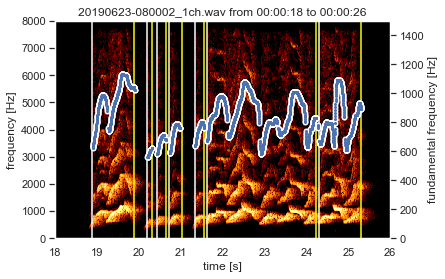

In [9]:
import parselmouth

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

snd_all = parselmouth.Sound('sample_wav/20190623-080002_1ch_120sec.wav')
# snd_part = snd_all.extract_part(from_time = 0.0, to_time = 60.0)
# pitch_val = snd_all.to_pitch(pitch_floor = 350, pitch_ceiling = 1500)

res = np.load("results/20200624_152128/20190623-080002_1ch.npy")
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

pitch = snd_all.to_pitch(pitch_floor = 350, pitch_ceiling = 1500)
# pitch = pitch.kill_octave_jumps()
pitch = pitch.smooth()
# If desired, pre-emphasize the sound fragment before calculating the spectrogram
pre_emphasized_snd = snd_all.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.03, maximum_frequency=8000)
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
# plt.xlim([snd.xmin, snd.xmax])
# plt.plot(pitch.xs()[:1500],pitch_values[:1500]*200)
plt.xlim([18,26])
for i, onset_offset_loc in enumerate(res[:,0]):
    plt.vlines(onset_offset_loc * pitch.dt, ymin = 0, ymax = 8000, colors="white")
for i, onset_offset_loc in enumerate(res[:,1]):
    plt.vlines(onset_offset_loc * pitch.dt, ymin = 0, ymax = 8000, colors="yellow")
plt.title('20190623-080002_1ch.wav from 00:00:18 to 00:00:26')

# plt.show() # or plt.savefig("spectrogram_0.03.pdf")
plt.savefig("20190623-080002_1ch_18sec_26sec.png",dpi=300)

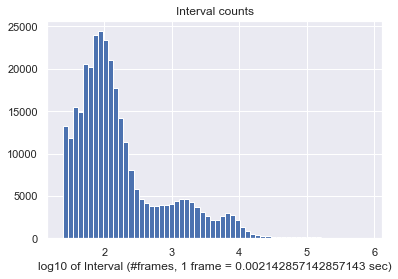

In [86]:
# plot inter-call intervals

import glob
import numpy as np
import matplotlib.pyplot as plt

fn_s = glob.glob('results/20200624_152128/*.npy')
ary_all = np.array([0.0,0.0,0.0])
ary_interval_s = np.zeros(1)
for fn in fn_s:
    ary_tmp = np.load(fn)
    ary_all = np.vstack([ary_all,ary_tmp])
    interval_tmp = ary_tmp[1:,0] - ary_tmp[:-1,1]
    ary_interval_s = np.append(ary_interval_s,interval_tmp)
ary_interval_s_nonzero = ary_interval_s[ary_interval_s > 0]
plt.hist(np.log10(ary_interval_s_nonzero),bins = 60)
plt.xlabel("log10 of Interval (#frames, 1 frame = 0.002142857142857143 sec)")
plt.title('Interval counts')
plt.savefig('hist_log_interval_bins_60.png')

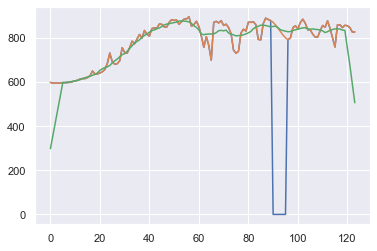

In [154]:
# plot pitch contour, interpolation, and smoothing.

import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
test_pitch_data = np.load('results/20200625_164810/20190614-070001_1ch_pitch.npy')
test_onset_offset = np.load('results/20200625_164810/20190614-070001_1ch.npy')

test_detected_voc = test_pitch_data[test_onset_offset[0,0] + 1:test_onset_offset[0,1] + 1]
value = test_detected_voc[test_detected_voc != 0]
loc = np.where(test_detected_voc != 0)[0]
test_detected_voc_interpolate = interpolate.interp1d(loc,value,kind="cubic")

v = np.ones(10,)/10

test_detected_voc_interpolate_ma = np.convolve(
    test_detected_voc_interpolate(np.arange(len(test_detected_voc))),
    v=v,
    mode = 'same'
    )

plt.plot(test_detected_voc)
plt.plot(test_detected_voc_interpolate(np.arange(len(test_detected_voc))))
plt.plot(test_detected_voc_interpolate_ma)

plt.show()

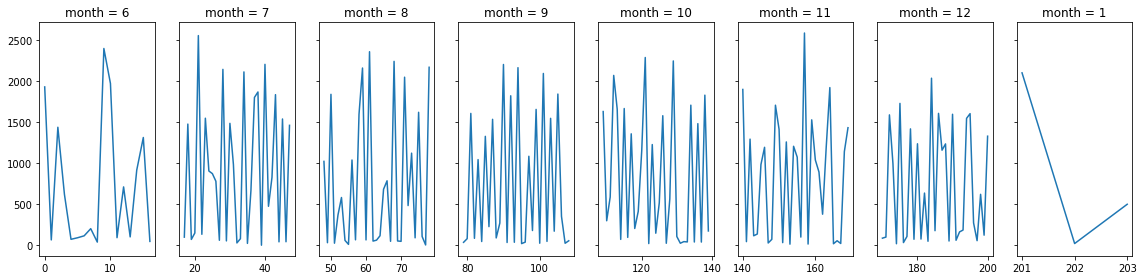

In [434]:
# 総発声量の日別経過をまとめる
# 季節変化を期待したが，目立つ傾向なし

import glob
import numpy as np
import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

fn_s = glob.glob('results/20200625_164810/*_1ch.npy')
fn_s.sort()

record_datetime_s = []
vocal_activity_s = []
for fn in fn_s:
    record_datetime_str = os.path.basename(fn).split('_')[0][:-2]
    record_datetime = datetime.datetime.strptime(record_datetime_str, '%Y%m%d-%H%M')
    record_datetime_s.append(record_datetime)
    onset_offset = np.load(fn)
    vocal_activity_s.append(
        np.sum(onset_offset[:,2]) * 0.75 / 350
    )
df_vocal_act = pd.DataFrame(
    {
        "datetime": record_datetime_s,
        "vocal_activity": vocal_activity_s,
    }
    )
df_vocal_act['date'] = df_vocal_act["datetime"].map(lambda x: x.date())
df_vocal_act['time'] = df_vocal_act["datetime"].map(lambda x: x.time())
df_vocal_act['month'] = df_vocal_act["datetime"].map(lambda x: x.month)
df_vocal_act['hour'] = df_vocal_act["datetime"].map(lambda x: str(x.hour))

df_vocal_act_by_date = pd.DataFrame(
    {
        "vocal_activity":df_vocal_act.groupby("date").vocal_activity.sum().values,
        "date": df_vocal_act["date"].unique()
    }
)

df_vocal_act_by_date["month"] = df_vocal_act_by_date["date"].map(lambda x: x.month)

# 日毎の発声量集計
# vocal activity of the day (cumulative duration of singing time in a day)
fig, ax = plt.subplots(ncols=8,figsize = (16,4),sharey=True)
for i, month in enumerate(df_vocal_act_by_date.month.unique()):
    ax[i].plot(df_vocal_act_by_date[df_vocal_act_by_date.month == month].vocal_activity)
    ax[i].set_title("month = %s" %str(month))    
plt.tight_layout()
plt.savefig("vocal_activity_by_date.png", dpi = 150)

Text(0.5, 0, 'log duration (sec) of the vocal activity in a day ')

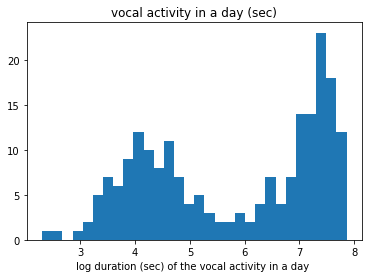

In [475]:
# plot histgrams of the vocal activity in a day
# plt.hist(np.log10(df_vocal_act_by_date[df_vocal_act_by_date.vocal_activity > 0].vocal_activity), bins=30)
plt.hist(np.log(df_vocal_act_by_date.vocal_activity + 10), bins=30)
# plt.hist(df_vocal_act_by_date.vocal_activity+0.001, bins=100)
plt.title("vocal activity in a day (sec)")
plt.xlabel("log duration (sec) of the vocal activity in a day ")
# plt.savefig("histogram_of_vocal_activity_by_date.png", dpi=150)

In [451]:
df_vocal_act_by_date[df_vocal_act_by_date.vocal_activity > 5].vocal_activity.max()

2583.4585714285718

(array([64., 22.,  6.,  3.,  4.,  4.,  3.,  5.,  1.,  3.,  4.,  4.,  6.,
         6.,  5.,  4.,  5.,  9.,  9.,  5.,  2.,  6.,  4.,  3.,  4.,  6.,
         2.,  2.,  0.,  2.]),
 array([   2.99785714,   89.01321429,  175.02857143,  261.04392857,
         347.05928571,  433.07464286,  519.09      ,  605.10535714,
         691.12071429,  777.13607143,  863.15142857,  949.16678571,
        1035.18214286, 1121.1975    , 1207.21285714, 1293.22821429,
        1379.24357143, 1465.25892857, 1551.27428571, 1637.28964286,
        1723.305     , 1809.32035714, 1895.33571429, 1981.35107143,
        2067.36642857, 2153.38178571, 2239.39714286, 2325.4125    ,
        2411.42785714, 2497.44321429, 2583.45857143]),
 <a list of 30 Patch objects>)

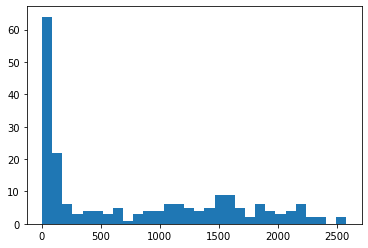

In [433]:
# plot histgrams of the vocal activity in a day
plt.hist(df_vocal_act_by_date[df_vocal_act_by_date.vocal_activity > 0].vocal_activity, bins=30)

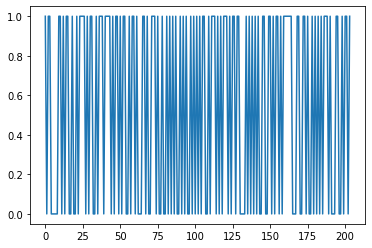

In [429]:
vocal_activity_by_date = df_vocal_act.groupby("date").vocal_activity.sum().values
vocal_activity_by_date[vocal_activity_by_date <= 10**2.5] = 0
vocal_activity_by_date[vocal_activity_by_date > 0] = 1
plt.plot(vocal_activity_by_date)

In [431]:
np.sum(np.abs(np.diff(vocal_activity_by_date)))/len(vocal_activity_by_date)

0.6666666666666666

In [240]:
# 日毎-月別・時間別の集計(中央値での表記)
# 強いて言えば，1)６時台は6月ピークで下がっていき様子．2)常に7時台がピーク，3)11月は非常に歌っている
df_vocal_act.groupby(["month","hour"]).vocal_activity.median()

month  hour
1      6         0.055714
       7       242.853214
       8         9.551786
       9         0.227143
6      14        0.056786
       6        31.982143
       7        47.905714
       8         4.246071
       9         1.128214
7      6         0.541071
       7       104.450357
       8         3.698571
       9         0.424286
8      6         2.227500
       7         9.585000
       8         5.767500
       9         0.731786
9      6         0.060000
       7        28.758214
       8        14.705357
       9         0.811071
10     6         0.413571
       7        25.067143
       8        28.029643
       9         0.683571
11     6         0.227143
       7       106.778571
       8         3.837857
       9         1.203214
12     6         0.160714
       7        63.325714
       8         5.755714
       9         1.114286
Name: vocal_activity, dtype: float64

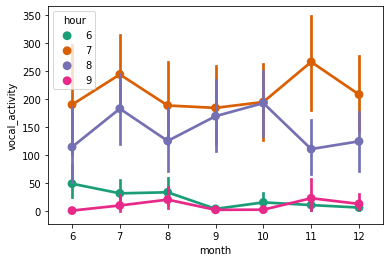

In [436]:
sns.pointplot(x='month', y='vocal_activity', data=df_vocal_act.query('month >= 6 and hour != "14"'), hue='hour', palette='Dark2')
plt.savefig("vocal_activity_month_hour.png", dpi = 150)

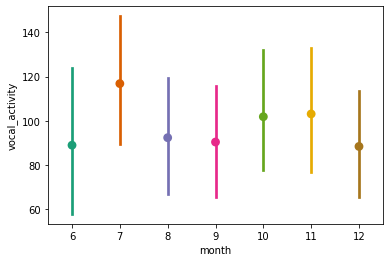

In [241]:
sns.pointplot(x='month', y='vocal_activity', data=df_vocal_act.query('month >= 6 and hour != "14"'), palette='Dark2')

In [273]:
df_vocal_act_by_date = pd.DataFrame(
    {
        "vocal_activity":df_vocal_act.groupby("date").vocal_activity.sum().values,
        "date": df_vocal_act["date"].unique()
    }
)
df_vocal_act_by_date["month"] = df_vocal_act_by_date["date"].map(lambda x: x.month)

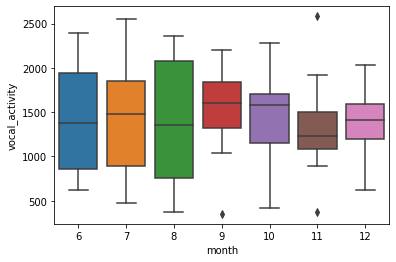

In [317]:
sns.boxplot(data = df_vocal_act_by_date.query('month >= 6 and vocal_activity > 300'), x = "month", y = "vocal_activity")

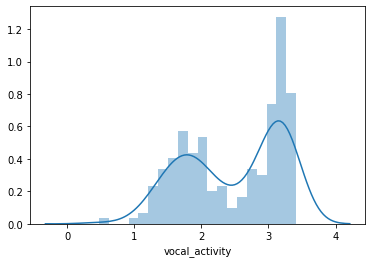

In [313]:
sns.distplot(a=np.log10(df_vocal_act_by_date[df_vocal_act_by_date.vocal_activity > 0].vocal_activity), kde=True, bins=20)

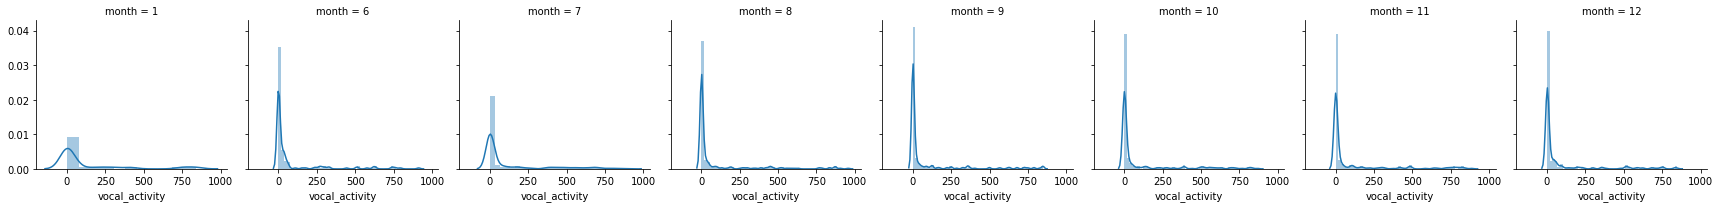

In [238]:
g = sns.FacetGrid(df_vocal_act,col = "month")
g = g.map(sns.distplot,"vocal_activity")

(array([737241., 737272., 737303., 737333., 737364., 737394., 737425.]),
 <a list of 7 Text xticklabel objects>)

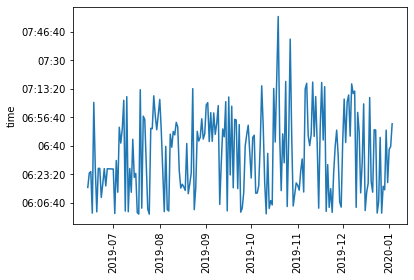

In [239]:
# calc sing start time:
# 発声開始時刻の季節変化のを期待したが，目立つ傾向はなし

fn_s = glob.glob('results/20200625_164810/*_1ch.npy')
fn_s.sort()

record_datetime_s = []
song_start_datetime_s = []
song_start_date_s = []
song_start_time_s = []

for fn in fn_s:
    record_datetime_str = os.path.basename(fn).split('_')[0]
    record_datetime = datetime.datetime.strptime(record_datetime_str, '%Y%m%d-%H%M%S')
#     record_datetime_s.append(record_datetime)
    onset_offset = np.load(fn)
    if len(onset_offset) != 0:
        for onset in onset_offset[:,0]:
            elapsed_time_sec = onset * (0.75/350)
            song_start_datetime_s.append(
                record_datetime + datetime.timedelta(seconds = elapsed_time_sec)
            )
            song_start_date_s.append(
                song_start_datetime_s[-1].date()
            )
            song_start_time_s.append(
                song_start_datetime_s[-1].time()
            )
df_song_start_datetime = pd.DataFrame(
    {
        "datetime": song_start_datetime_s,
        "date": song_start_date_s,
        "time": song_start_time_s,
    }
)
plt.plot(df_song_start_datetime.date.unique(),df_song_start_datetime.groupby("date").time.min())
plt.xticks(rotation=90)

In [321]:
df_song_start_datetime["month"] = df_song_start_datetime["datetime"].map(lambda x: x.month)

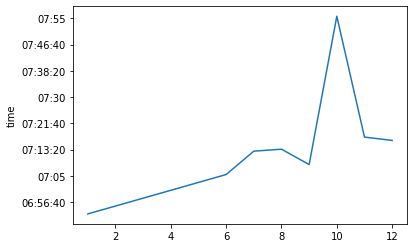

In [332]:
plt.plot(df_song_start_datetime.groupby("date")["time","month"].min().groupby("month")["time"].max())

In [333]:
df_song_start_datetime.groupby("date")["time","month"].min().groupby("month")["time"].max()

month
1     06:52:55.337857
6     07:05:25.447143
7     07:12:50.677857
8     07:13:28.402143
9     07:08:35.657857
10    07:55:41.034286
11    07:17:18.667143
12    07:16:15.395714
Name: time, dtype: object

In [483]:
# make graph of 2-states HMM explaining vocal activity by date.

from graphviz import Graph
from graphviz import Digraph

dg = Digraph(format='png')
dg.attr(rankdir="LR")
dg.node('1', label = 'state 1')
dg.node('2', label = 'state 2')
dg.edge('1', '2', label = '0.67')  # 1 -> 2
dg.edge('2', '1', label = '0.71')  # 2 -> 1
dg.edge('1', '1', label = '0.33')  # 1 -> 2
dg.edge('2', '2', label = '0.29')  # 2 -> 1
# dg.view()
dg.render("../analyze/hmm_graph")

'../analyze/hmm_graph.png'

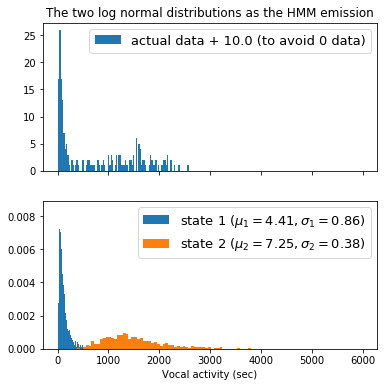

In [505]:
import matplotlib.pyplot as plt
import numpy as np
mu_1, sigma_1 = 4.41, 0.86
mu_2, sigma_2 = 7.25, 0.38

s_1 = np.random.lognormal(mu_1, sigma_1, 1000)
s_2 = np.random.lognormal(mu_2, sigma_2, 1000)

fig, ax = plt.subplots(2,1, figsize = (6,6), sharex=True)


ax[0].hist(df_vocal_act_by_date.vocal_activity + 10, bins=100, label = "actual data + 10.0 (to avoid 0 data)")
ax[0].legend(loc="upper right", fontsize=13)

ax[1].hist(s_1, 100, density=True, align='mid', label = "state 1 ($\mu_{1} = %1.2f, \sigma_{1} = 0.86$)" %mu_1)
ax[1].hist(s_2, 100, density=True, align='mid', label = "state 2 ($\mu_{2} = %1.2f, \sigma_{2} = 0.38$)" %mu_2)
ax[1].legend(loc="upper right", fontsize=13)

ax[0].set_title("The two log normal distributions as the HMM emission")

ax[1].set_xlabel("Vocal activity (sec)")

# plt.show()
plt.savefig("../analyze/HMM_lognormal_emissions.png", dpi = 150)